In [1]:
import torchvision
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from mask_utils.engine import train_one_epoch, evaluate
import os
import numpy as np
import torch
from PIL import Image
import mask_utils.transforms as T
import mask_utils.utils as utils
import cv2

In [2]:

class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "labels"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "labels", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path).convert("LA")
        mask = cv2.imread(mask_path,0)
        # convert the PIL Image into a numpy array
        mask = np.array(mask) 
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:] 
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]  
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [26]:
def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('dataset/cells', get_transform(train=True))
    dataset_test = PennFudanDataset('dataset/cells', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    print (len(indices))
    dataset = torch.utils.data.Subset(dataset, indices[:45])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-5:])
    print (len(dataset),len(dataset_test))
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes) 
    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=5,
                                                   gamma=0.051)

    # let's train it for 10 epochs
    num_epochs = 30

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=5)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        if (epoch+5) % 10 == 0:
            evaluate(model, data_loader_test, device=device)
    return model, data_loader_test,data_loader
    print("That's it!")

In [27]:
model, test_loader,train_loader = main()

50
45 5
Epoch: [0]  [ 0/23]  eta: 0:01:29  lr: 0.000232  loss: 8.4652 (8.4652)  loss_classifier: 0.7075 (0.7075)  loss_box_reg: 0.4710 (0.4710)  loss_mask: 2.7648 (2.7648)  loss_objectness: 4.1729 (4.1729)  loss_rpn_box_reg: 0.3490 (0.3490)  time: 3.8717  data: 3.4268  max mem: 4250
Epoch: [0]  [ 5/23]  eta: 0:00:19  lr: 0.001367  loss: 3.1664 (4.9581)  loss_classifier: 0.5809 (0.6119)  loss_box_reg: 0.4710 (0.4782)  loss_mask: 1.5958 (1.9143)  loss_objectness: 0.3244 (1.6816)  loss_rpn_box_reg: 0.2186 (0.2722)  time: 1.0733  data: 0.6804  max mem: 4590
Epoch: [0]  [10/23]  eta: 0:00:12  lr: 0.002502  loss: 2.4891 (3.6775)  loss_classifier: 0.5224 (0.5645)  loss_box_reg: 0.4843 (0.4838)  loss_mask: 1.0122 (1.3651)  loss_objectness: 0.2614 (1.0107)  loss_rpn_box_reg: 0.2218 (0.2534)  time: 0.9407  data: 0.5510  max mem: 4590
Epoch: [0]  [15/23]  eta: 0:00:07  lr: 0.003638  loss: 2.0832 (3.1361)  loss_classifier: 0.5148 (0.5419)  loss_box_reg: 0.4843 (0.4855)  loss_mask: 0.6227 (1.0726) 

Epoch: [4]  [22/23]  eta: 0:00:00  lr: 0.005000  loss: 0.9529 (0.9169)  loss_classifier: 0.2034 (0.2174)  loss_box_reg: 0.1714 (0.1758)  loss_mask: 0.2521 (0.2597)  loss_objectness: 0.0489 (0.0531)  loss_rpn_box_reg: 0.2105 (0.2109)  time: 0.7946  data: 0.4187  max mem: 4610
Epoch: [4] Total time: 0:00:22 (0.9800 s / it)
Epoch: [5]  [ 0/23]  eta: 0:01:51  lr: 0.000255  loss: 1.1328 (1.1328)  loss_classifier: 0.2735 (0.2735)  loss_box_reg: 0.2366 (0.2366)  loss_mask: 0.3077 (0.3077)  loss_objectness: 0.0599 (0.0599)  loss_rpn_box_reg: 0.2551 (0.2551)  time: 4.8570  data: 4.4679  max mem: 4610
Epoch: [5]  [ 5/23]  eta: 0:00:33  lr: 0.000255  loss: 0.8555 (0.8866)  loss_classifier: 0.1917 (0.2075)  loss_box_reg: 0.1492 (0.1667)  loss_mask: 0.2434 (0.2501)  loss_objectness: 0.0359 (0.0406)  loss_rpn_box_reg: 0.2201 (0.2218)  time: 1.8643  data: 1.4711  max mem: 4610
Epoch: [5]  [10/23]  eta: 0:00:15  lr: 0.000255  loss: 0.8555 (0.8949)  loss_classifier: 0.1970 (0.2050)  loss_box_reg: 0.157

Epoch: [8]  [10/23]  eta: 0:00:10  lr: 0.000255  loss: 0.8252 (0.8655)  loss_classifier: 0.2034 (0.2047)  loss_box_reg: 0.1569 (0.1661)  loss_mask: 0.2617 (0.2614)  loss_objectness: 0.0423 (0.0402)  loss_rpn_box_reg: 0.1757 (0.1932)  time: 0.7876  data: 0.3963  max mem: 4633
Epoch: [8]  [15/23]  eta: 0:00:06  lr: 0.000255  loss: 0.7909 (0.8266)  loss_classifier: 0.1708 (0.1915)  loss_box_reg: 0.1515 (0.1550)  loss_mask: 0.2416 (0.2503)  loss_objectness: 0.0399 (0.0401)  loss_rpn_box_reg: 0.1702 (0.1896)  time: 0.7643  data: 0.3740  max mem: 4633
Epoch: [8]  [20/23]  eta: 0:00:02  lr: 0.000255  loss: 0.8252 (0.8267)  loss_classifier: 0.1774 (0.1910)  loss_box_reg: 0.1517 (0.1566)  loss_mask: 0.2533 (0.2547)  loss_objectness: 0.0285 (0.0377)  loss_rpn_box_reg: 0.1731 (0.1867)  time: 0.6239  data: 0.2360  max mem: 4633
Epoch: [8]  [22/23]  eta: 0:00:00  lr: 0.000255  loss: 0.8252 (0.8279)  loss_classifier: 0.1774 (0.1916)  loss_box_reg: 0.1537 (0.1591)  loss_mask: 0.2533 (0.2555)  loss_ob

Epoch: [13]  [ 5/23]  eta: 0:00:20  lr: 0.000013  loss: 0.9124 (0.9032)  loss_classifier: 0.1922 (0.2081)  loss_box_reg: 0.1813 (0.1780)  loss_mask: 0.2643 (0.2652)  loss_objectness: 0.0418 (0.0474)  loss_rpn_box_reg: 0.2313 (0.2045)  time: 1.1383  data: 0.7542  max mem: 4633
Epoch: [13]  [10/23]  eta: 0:00:12  lr: 0.000013  loss: 0.9304 (0.9351)  loss_classifier: 0.1995 (0.2140)  loss_box_reg: 0.1860 (0.1853)  loss_mask: 0.2643 (0.2641)  loss_objectness: 0.0428 (0.0511)  loss_rpn_box_reg: 0.2313 (0.2206)  time: 0.9330  data: 0.5428  max mem: 4633
Epoch: [13]  [15/23]  eta: 0:00:06  lr: 0.000013  loss: 0.8818 (0.8655)  loss_classifier: 0.1922 (0.1975)  loss_box_reg: 0.1652 (0.1667)  loss_mask: 0.2542 (0.2547)  loss_objectness: 0.0395 (0.0433)  loss_rpn_box_reg: 0.1762 (0.2033)  time: 0.8415  data: 0.4523  max mem: 4633
Epoch: [13]  [20/23]  eta: 0:00:02  lr: 0.000013  loss: 0.8043 (0.8414)  loss_classifier: 0.1867 (0.1925)  loss_box_reg: 0.1617 (0.1649)  loss_mask: 0.2542 (0.2553)  los

Epoch: [16]  [20/23]  eta: 0:00:02  lr: 0.000001  loss: 0.7863 (0.8148)  loss_classifier: 0.1891 (0.1840)  loss_box_reg: 0.1622 (0.1586)  loss_mask: 0.2538 (0.2528)  loss_objectness: 0.0351 (0.0392)  loss_rpn_box_reg: 0.1546 (0.1802)  time: 0.6912  data: 0.3038  max mem: 4633
Epoch: [16]  [22/23]  eta: 0:00:00  lr: 0.000001  loss: 0.8386 (0.8073)  loss_classifier: 0.1875 (0.1840)  loss_box_reg: 0.1652 (0.1568)  loss_mask: 0.2490 (0.2504)  loss_objectness: 0.0374 (0.0384)  loss_rpn_box_reg: 0.1631 (0.1776)  time: 0.6812  data: 0.3040  max mem: 4633
Epoch: [16] Total time: 0:00:19 (0.8324 s / it)
Epoch: [17]  [ 0/23]  eta: 0:01:10  lr: 0.000001  loss: 0.6978 (0.6978)  loss_classifier: 0.1683 (0.1683)  loss_box_reg: 0.1193 (0.1193)  loss_mask: 0.2185 (0.2185)  loss_objectness: 0.0206 (0.0206)  loss_rpn_box_reg: 0.1711 (0.1711)  time: 3.0706  data: 2.6697  max mem: 4633
Epoch: [17]  [ 5/23]  eta: 0:00:18  lr: 0.000001  loss: 0.9234 (0.9027)  loss_classifier: 0.2110 (0.2175)  loss_box_reg: 

Epoch: [21]  [15/23]  eta: 0:00:07  lr: 0.000000  loss: 0.7184 (0.8225)  loss_classifier: 0.1687 (0.1905)  loss_box_reg: 0.1491 (0.1684)  loss_mask: 0.2495 (0.2582)  loss_objectness: 0.0303 (0.0334)  loss_rpn_box_reg: 0.1783 (0.1721)  time: 0.9337  data: 0.5455  max mem: 4633
Epoch: [21]  [20/23]  eta: 0:00:02  lr: 0.000000  loss: 0.7184 (0.8016)  loss_classifier: 0.1687 (0.1864)  loss_box_reg: 0.1474 (0.1591)  loss_mask: 0.2431 (0.2520)  loss_objectness: 0.0303 (0.0334)  loss_rpn_box_reg: 0.1629 (0.1708)  time: 0.8824  data: 0.4946  max mem: 4633
Epoch: [21]  [22/23]  eta: 0:00:00  lr: 0.000000  loss: 0.7184 (0.8155)  loss_classifier: 0.1687 (0.1871)  loss_box_reg: 0.1474 (0.1586)  loss_mask: 0.2431 (0.2529)  loss_objectness: 0.0306 (0.0335)  loss_rpn_box_reg: 0.1629 (0.1833)  time: 0.7194  data: 0.3412  max mem: 4633
Epoch: [21] Total time: 0:00:19 (0.8390 s / it)
Epoch: [22]  [ 0/23]  eta: 0:01:08  lr: 0.000000  loss: 0.8997 (0.8997)  loss_classifier: 0.2514 (0.2514)  loss_box_reg: 

Epoch: [26]  [ 0/23]  eta: 0:01:07  lr: 0.000000  loss: 0.5511 (0.5511)  loss_classifier: 0.1543 (0.1543)  loss_box_reg: 0.0912 (0.0912)  loss_mask: 0.2027 (0.2027)  loss_objectness: 0.0130 (0.0130)  loss_rpn_box_reg: 0.0899 (0.0899)  time: 2.9391  data: 2.5476  max mem: 4633
Epoch: [26]  [ 5/23]  eta: 0:00:24  lr: 0.000000  loss: 0.7198 (0.7516)  loss_classifier: 0.1543 (0.1700)  loss_box_reg: 0.1272 (0.1446)  loss_mask: 0.2395 (0.2429)  loss_objectness: 0.0255 (0.0327)  loss_rpn_box_reg: 0.1298 (0.1614)  time: 1.3487  data: 0.9616  max mem: 4633
Epoch: [26]  [10/23]  eta: 0:00:16  lr: 0.000000  loss: 0.8217 (0.8415)  loss_classifier: 0.1845 (0.1882)  loss_box_reg: 0.1635 (0.1660)  loss_mask: 0.2577 (0.2588)  loss_objectness: 0.0296 (0.0355)  loss_rpn_box_reg: 0.2009 (0.1930)  time: 1.2843  data: 0.8927  max mem: 4633
Epoch: [26]  [15/23]  eta: 0:00:08  lr: 0.000000  loss: 0.7561 (0.8044)  loss_classifier: 0.1743 (0.1816)  loss_box_reg: 0.1555 (0.1602)  loss_mask: 0.2487 (0.2541)  los

In [68]:
def visualize(image,scores, threshold = 0.5):
    final_mask = np.zeros((image.shape[1],image.shape[2],3))
    for channel in image:
        channel[channel > threshold] = 1
        channel[channel<=threshold]=0
        final_mask[channel==1] = np.random.randint(1,255,size = 3).tolist()
        final_mask[final_mask>255]=255
    final_mask= final_mask.astype("uint8")
    plt.figure(figsize=(20,10))
    plt.imshow(final_mask)
    plt.show()
        
        

(38, 1022, 1024)


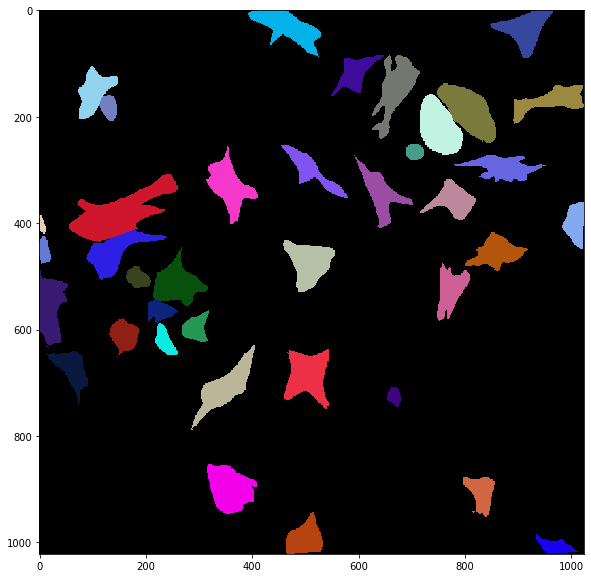

[{'boxes': tensor([[4.6507e+02, 6.3026e+02, 5.4964e+02, 7.3776e+02],
        [3.1556e+02, 8.4469e+02, 4.1430e+02, 9.4176e+02],
        [4.6310e+02, 4.3386e+02, 5.6406e+02, 5.2843e+02],
        [6.8365e+01, 1.0742e+02, 1.4859e+02, 2.1478e+02],
        [8.2714e+00, 6.3400e+02, 9.6044e+01, 7.4022e+02],
        [6.2533e+02, 8.7053e+01, 7.1430e+02, 2.3305e+02],
        [7.4874e+02, 4.8416e+02, 8.1242e+02, 5.8616e+02],
        [3.1719e+02, 2.5205e+02, 4.1170e+02, 4.0466e+02],
        [5.9099e+02, 2.6547e+02, 7.0431e+02, 4.0861e+02],
        [8.6220e-01, 5.0629e+02, 6.0043e+01, 6.3735e+02],
        [7.8602e+02, 2.6990e+02, 9.5069e+02, 3.2827e+02],
        [7.4893e+02, 1.3893e+02, 8.6210e+02, 2.5096e+02],
        [2.7825e+02, 6.2704e+02, 4.1480e+02, 7.9392e+02],
        [7.9153e+02, 8.7267e+02, 8.5202e+02, 9.4599e+02],
        [7.9586e+02, 4.1523e+02, 9.2276e+02, 4.9305e+02],
        [3.9327e+02, 1.3387e+00, 5.4477e+02, 8.8608e+01],
        [8.8805e+02, 1.3404e+02, 1.0240e+03, 2.0553e+02],
   

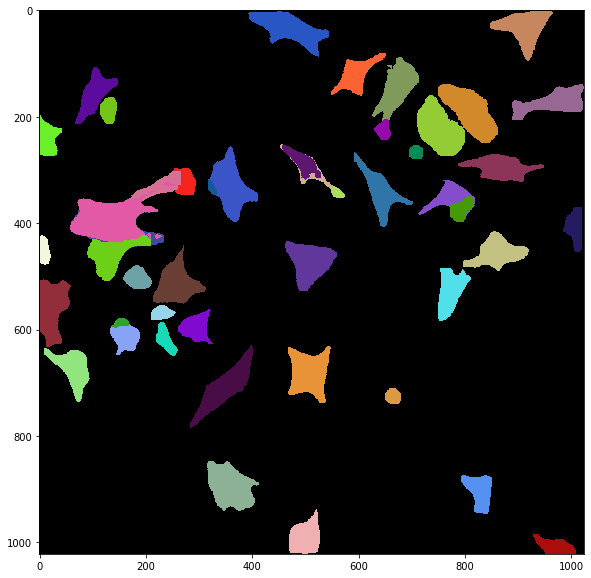

mask (47, 1022, 1024) 





(47, 1022, 1024)


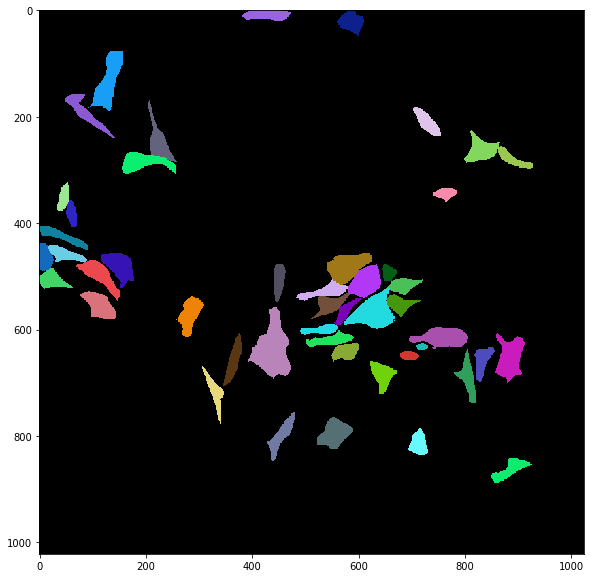

[{'boxes': tensor([[7.7763e+02, 6.3963e+02, 8.2314e+02, 7.4177e+02],
        [8.4809e+02, 8.4301e+02, 9.3171e+02, 8.9052e+02],
        [8.5671e+02, 6.0802e+02, 9.1297e+02, 6.9696e+02],
        [4.2631e+02, 7.5608e+02, 4.8244e+02, 8.4333e+02],
        [3.9598e+02, 5.5434e+02, 4.7451e+02, 6.9959e+02],
        [7.6936e+01, 5.2373e+02, 1.4351e+02, 5.7623e+02],
        [3.4720e+02, 6.0532e+02, 3.8520e+02, 7.0221e+02],
        [9.9212e+01, 7.5668e+01, 1.6005e+02, 1.9695e+02],
        [6.6244e+02, 5.3495e+02, 7.1958e+02, 5.7462e+02],
        [5.1865e+02, 7.6291e+02, 5.9142e+02, 8.1944e+02],
        [5.4862e+02, 6.2471e+02, 6.0174e+02, 6.5749e+02],
        [7.0330e+02, 1.8172e+02, 7.5634e+02, 2.3603e+02],
        [6.1984e+02, 6.5547e+02, 6.7469e+02, 7.1910e+02],
        [2.5861e+02, 5.3747e+02, 3.0765e+02, 6.1288e+02],
        [7.1541e-02, 3.9947e+02, 9.0836e+01, 4.4617e+02],
        [6.8656e+02, 5.9265e+02, 8.0374e+02, 6.3501e+02],
        [3.4529e+01, 3.2405e+02, 7.2694e+01, 4.0455e+02],
   

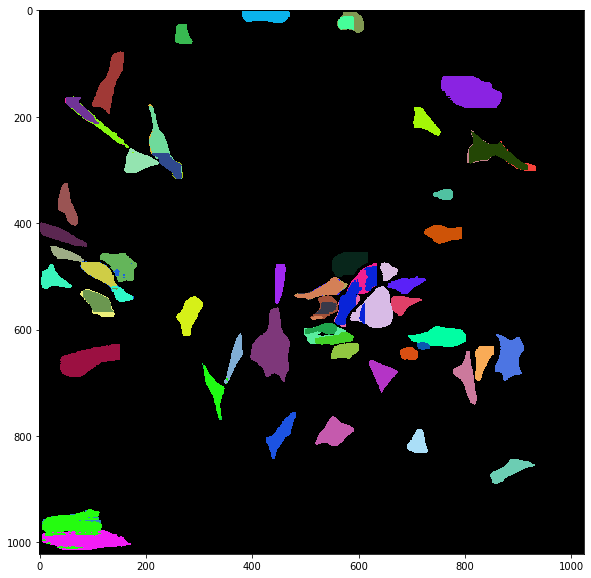

mask (68, 1022, 1024) 





(47, 1022, 1024)


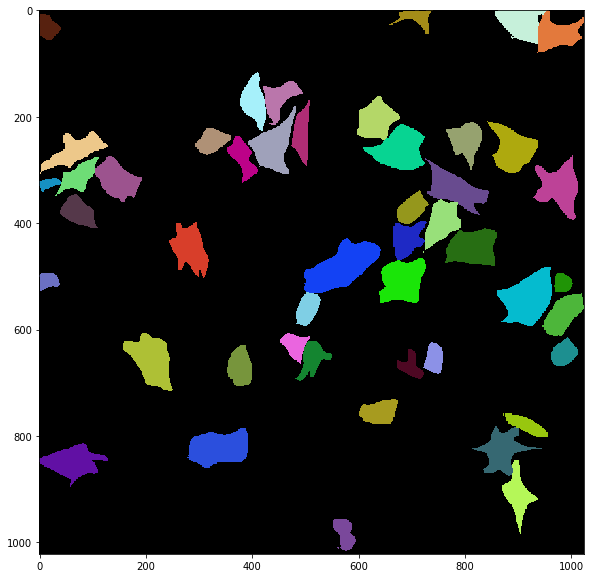

[{'boxes': tensor([[1.5770e+02, 6.0588e+02, 2.4914e+02, 7.1319e+02],
        [2.4672e+02, 3.9383e+02, 3.1852e+02, 4.9919e+02],
        [9.2317e+02, 2.7760e+02, 1.0119e+03, 3.9223e+02],
        [9.3042e+02, 6.8865e+00, 1.0239e+03, 8.2715e+01],
        [7.6222e+02, 2.1550e+02, 8.3073e+02, 3.0951e+02],
        [5.9985e+02, 1.6326e+02, 6.7953e+02, 2.4518e+02],
        [4.8088e+00, 2.3085e+02, 1.3051e+02, 3.0551e+02],
        [8.8029e+02, 7.5508e+02, 9.5255e+02, 8.0227e+02],
        [4.8181e+00, 8.1365e+02, 1.2767e+02, 8.9427e+02],
        [8.3735e+02, 2.0629e+02, 9.3328e+02, 3.1004e+02],
        [7.1390e+02, 2.6647e+02, 8.4537e+02, 3.8640e+02],
        [4.9391e+02, 4.2883e+02, 6.3332e+02, 5.2880e+02],
        [3.5884e+02, 2.3583e+02, 4.0905e+02, 3.2096e+02],
        [8.5991e+02, 4.8180e+02, 9.6198e+02, 5.9407e+02],
        [4.8187e+02, 6.1794e+02, 5.5071e+02, 6.9248e+02],
        [7.5310e+02, 4.0971e+02, 8.6869e+02, 4.8654e+02],
        [8.0994e+02, 7.7979e+02, 9.1604e+02, 8.6845e+02],
   

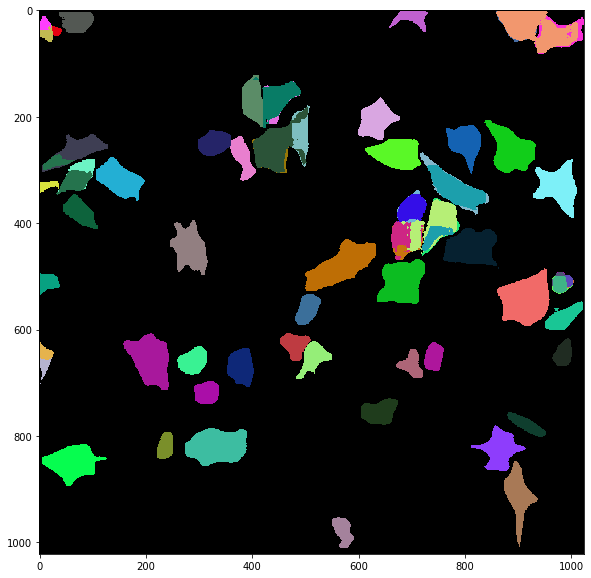

mask (68, 1022, 1024) 





(53, 1022, 1024)


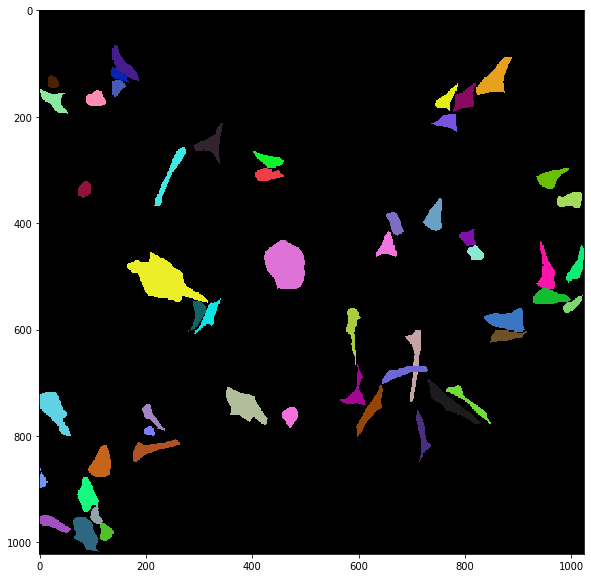

[{'boxes': tensor([[4.0184e+02, 2.6572e+02, 4.6418e+02, 2.9691e+02],
        [3.5248e+02, 7.0728e+02, 4.3035e+02, 7.7417e+02],
        [2.7928e+02, 5.3534e+02, 3.4357e+02, 6.0811e+02],
        [1.0022e+00, 7.1665e+02, 5.9736e+01, 7.9827e+02],
        [9.7971e+02, 5.3546e+02, 1.0206e+03, 5.7057e+02],
        [8.3650e+02, 5.5949e+02, 9.1636e+02, 6.0055e+02],
        [5.9604e+02, 7.0769e+02, 6.4767e+02, 7.9445e+02],
        [8.4245e+02, 5.9850e+02, 9.2469e+02, 6.2703e+02],
        [1.7903e+02, 8.0670e+02, 2.6378e+02, 8.4419e+02],
        [9.9304e+02, 4.4331e+02, 1.0240e+03, 5.1021e+02],
        [4.0697e+02, 2.9764e+02, 4.6334e+02, 3.2026e+02],
        [4.4497e+00, 1.5275e+02, 6.1017e+01, 2.0082e+02],
        [1.3963e+00, 9.4434e+02, 6.1083e+01, 9.8231e+02],
        [1.3575e+02, 7.0656e+01, 1.8370e+02, 1.3375e+02],
        [4.2557e+02, 4.3819e+02, 5.0041e+02, 5.2570e+02],
        [2.9462e+02, 2.1478e+02, 3.4387e+02, 2.9943e+02],
        [9.6441e+01, 8.1685e+02, 1.3853e+02, 8.7885e+02],
   

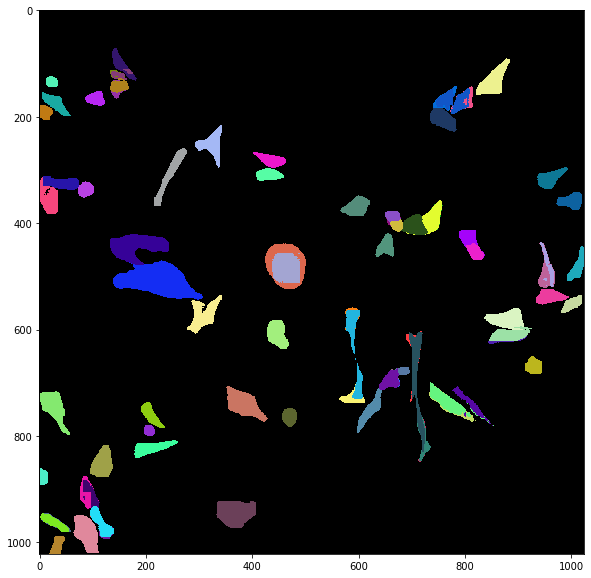

mask (83, 1022, 1024) 





(85, 1022, 1024)


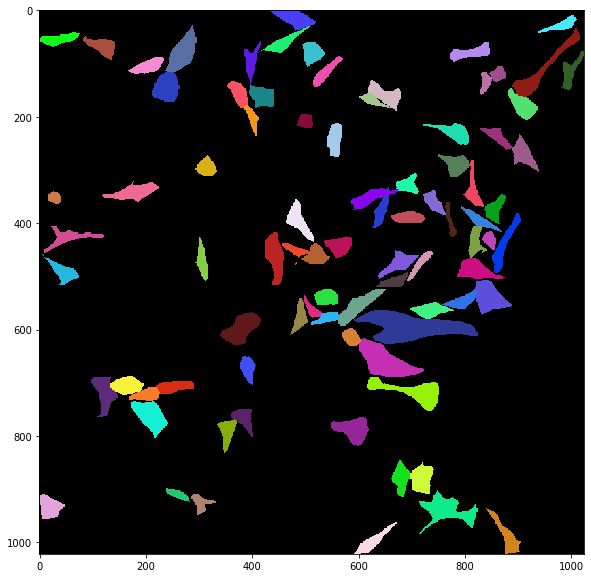

[{'boxes': tensor([[8.4396e+02, 3.8525e+02, 9.0460e+02, 4.9178e+02],
        [5.1107e+02, 8.8765e+01, 5.6881e+02, 1.4467e+02],
        [1.6645e+02, 9.1991e+01, 2.3354e+02, 1.2435e+02],
        [4.2441e+02, 4.1680e+02, 4.6049e+02, 5.1388e+02],
        [9.9790e+01, 6.8376e+02, 1.4679e+02, 7.6272e+02],
        [8.2598e+02, 2.1867e+02, 8.8436e+02, 2.6066e+02],
        [5.1643e+02, 7.6381e+02, 6.1630e+02, 8.1571e+02],
        [3.5382e+02, 5.7060e+02, 4.1598e+02, 6.1808e+02],
        [4.4909e+00, 4.5880e+02, 7.6203e+01, 5.1377e+02],
        [8.8607e+02, 2.3433e+02, 9.3743e+02, 3.0061e+02],
        [9.8077e+02, 8.4488e+01, 1.0208e+03, 1.5086e+02],
        [6.9829e+02, 5.3246e+02, 8.1737e+02, 5.8226e+02],
        [7.8758e+02, 4.6388e+02, 8.6207e+02, 5.0903e+02],
        [5.9614e+02, 9.5425e+02, 6.7929e+02, 1.0220e+03],
        [6.9523e+02, 8.4539e+02, 7.4198e+02, 9.0738e+02],
        [7.4893e+02, 2.7013e+02, 8.0249e+02, 3.1308e+02],
        [9.3830e+02, 9.9367e+00, 1.0052e+03, 4.4504e+01],
   

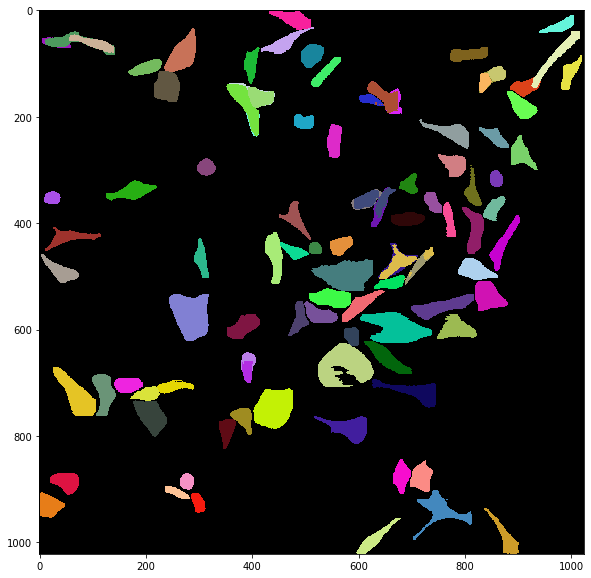

mask (100, 1022, 1024) 







In [72]:
import matplotlib.pyplot as plt

model.eval()
for image,_ in test_loader:
    image = list(img.to("cuda") for img in image)
    print(_[0]["masks"].cpu().detach().numpy().shape)
    visualize(_[0]["masks"].cpu().detach().numpy())
    target = np.sum(_[0]["masks"].cpu().detach().numpy(),0)
#     print (target.shape)
    outputs = model(image)
    scores =outputs[0]["scores"]
#     print (outputs[0]["masks"].shape)
    mask = outputs[0]["masks"].squeeze()
   
    mask = mask.cpu().detach().numpy()
    visualize(mask,scores)
    print ("mask",mask.shape,"\n\n\n\n\n")
#     print(len(image))
#     img = image[0].cpu().detach().numpy()
#     img = np.transpose(img,[1,2,0])
#     print (img.shape,"shape")
#     plt.figure(figsize=(20,10))
#     plt.imshow(mask)
#     plt.show()
   
    
     